In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(7,7)

from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import np_utils
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization

epochs = 20
input_shape = (28, 28, 1)
nb_classes = 10

path='./mnist.npz'
f = np.load(path)
X_train, y_train = f['x_train'], f['y_train']
X_test, y_test = f['x_test'], f['y_test']
f.close()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


Using TensorFlow backend.


X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


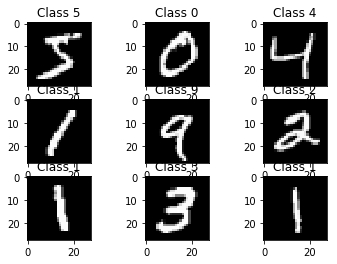

In [2]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))


In [3]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)



X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


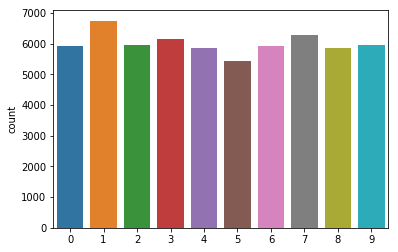

In [4]:
sns.countplot(y_train)

In [5]:
print("y_train:", y_train.shape)


y_train: (60000,)


In [6]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print("Y_train:", Y_train.shape)

Y_train: (60000, 10)


In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [8]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

datagen.fit(X_train)

filepath = 'model.hdf5'
from keras.callbacks import ModelCheckpoint

# monitor计算每一个模型validation_data的准确率
# save_best_only 只保存最好的一个模型
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, mode='max')





In [9]:
# steps_per_epoch指定循环次数
h = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=500),
                       steps_per_epoch=len(X_train)/1000, epochs=epochs,
                       validation_data=datagen.flow(X_test, Y_test, batch_size=len(X_test)),
                       validation_steps=1, callbacks=[checkpointer])

Epoch 1/20
60/60 [==============================] - 210s 4s/step - loss: 0.4644 - acc: 0.8577 - val_loss: 0.0811 - val_acc: 0.9744
Epoch 2/20
60/60 [==============================] - 217s 4s/step - loss: 0.1077 - acc: 0.9674 - val_loss: 0.0466 - val_acc: 0.9856
Epoch 3/20
60/60 [==============================] - 208s 3s/step - loss: 0.0725 - acc: 0.9779 - val_loss: 0.0364 - val_acc: 0.9895
Epoch 4/20
60/60 [==============================] - 208s 3s/step - loss: 0.0607 - acc: 0.9815 - val_loss: 0.0310 - val_acc: 0.9902
Epoch 5/20
60/60 [==============================] - 184s 3s/step - loss: 0.0517 - acc: 0.9849 - val_loss: 0.0300 - val_acc: 0.9905
Epoch 6/20
60/60 [==============================] - 182s 3s/step - loss: 0.0448 - acc: 0.9862 - val_loss: 0.0364 - val_acc: 0.9879
Epoch 7/20
60/60 [==============================] - 179s 3s/step - loss: 0.0382 - acc: 0.9883 - val_loss: 0.0231 - val_acc: 0.9934
Epoch 8/20
60/60 [==============================] - 180s 3s/step - loss: 0.0364 - a

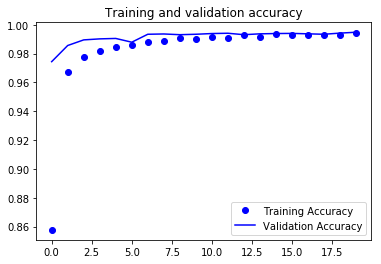

In [12]:
history = h.history
accuracy = history['acc']
val_accuracy = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


In [17]:
from keras.models import load_model
model = load_model('model.hdf5')
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 18s 2ms/step
Test score: 0.24558740867705864
Test accuracy: 0.984


In [15]:
score = model.evaluate(X_test, Y_test)
print("Test score:", score[0])
print("Test accuracy:", score[1])

10000/10000 [==============================] - 19s 2ms/step
Test score: 0.24558740867705864
Test accuracy: 0.984


In [39]:
predicted_classes = model.predict_classes(X_test)
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

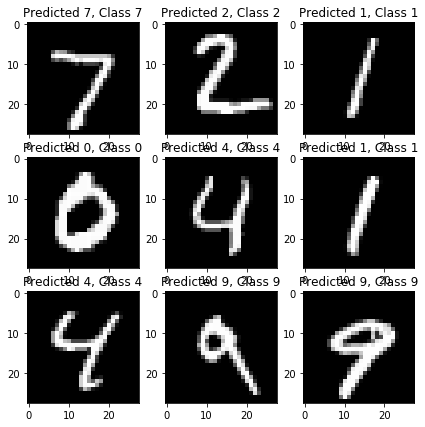

In [41]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    


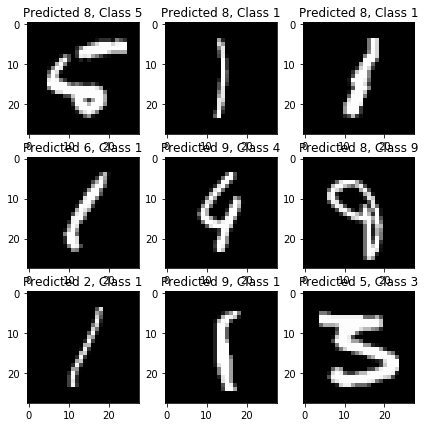

In [42]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
